# <font color='blue'>Projeto</font>
# <font color='blue'>Pré-Processamento de Dados de Texto Extraídos de Data Lake</font>

## Instalando e Carregando os Pacotes

In [1]:
# !pip install -q pymongo

In [2]:
# Imports
import json
import pymongo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Guilherme Goldoni" --iversions

Author: Guilherme Goldoni

seaborn   : 0.13.2
matplotlib: 3.10.3
IPython   : 8.29.0
numpy     : 1.26.4
pymongo   : 4.13.1
json      : 2.0.9
pandas    : 2.2.3
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]



## Conectando no Data Lake

In [4]:
# Abre a conexão
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [5]:
# Visualiza a conexão
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [6]:
# Cria um repositório (banco de dados) chamado datalake
datalake = client["datalake"]

In [7]:
datalake

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'datalake')

In [8]:
# Se existir, deleta a coleção chamada posts
datalake.posts.drop()

In [9]:
# Cria a coleção chamada posts
posts = datalake["posts"]

## Carregando Dados no Data Lake

In [10]:
# Carrega o arquivo json em uma variável Python
with open('dados/dataset.json') as file:
    file_data = json.load(file)

In [11]:
file_data[:10]

[{'status': 'public',
  'creationDate': '2017-07-17T20:05:49Z',
  'allowComments': True,
  'title': 'Concordo plenamente',
  'description': 'O post trouxe uma nova perspectiva. Adorei!',
  'tags': 1,
  'Category': 'lifestyle',
  'filteredPicture': False},
 {'status': 'private',
  'creationDate': '2019-01-19T15:45:57Z',
  'allowComments': False,
  'title': 'Adorei esse post!',
  'description': 'Me ajudou bastante com uma questão que eu tinha há tempos.',
  'tags': 0,
  'Category': 'lifestyle',
  'filteredPicture': False},
 {'status': 'private',
  'creationDate': '2019-03-22T17:18:15Z',
  'allowComments': True,
  'title': 'Interessante, mas tenho dúvidas',
  'description': 'Não concordo com tudo, mas respeito a opinião apresentada.',
  'tags': 6,
  'Category': 'politics',
  'filteredPicture': True},
 {'status': 'public',
  'creationDate': '2019-05-12T13:20:40Z',
  'allowComments': True,
  'title': 'Valeu pela dica!',
  'description': 'Conteúdo muito interessante! Já compartilhei com algu

In [12]:
# Insere o conteúdo do arquivo json na coleção chamada posts. Cada item do arquivo será um documento.
posts.insert_many(file_data, ordered = False, bypass_document_validation = True)

InsertManyResult([ObjectId('684ae69ccb03112702967a7e'), ObjectId('684ae69ccb03112702967a7f'), ObjectId('684ae69ccb03112702967a80'), ObjectId('684ae69ccb03112702967a81'), ObjectId('684ae69ccb03112702967a82'), ObjectId('684ae69ccb03112702967a83'), ObjectId('684ae69ccb03112702967a84'), ObjectId('684ae69ccb03112702967a85'), ObjectId('684ae69ccb03112702967a86'), ObjectId('684ae69ccb03112702967a87'), ObjectId('684ae69ccb03112702967a88'), ObjectId('684ae69ccb03112702967a89'), ObjectId('684ae69ccb03112702967a8a'), ObjectId('684ae69ccb03112702967a8b'), ObjectId('684ae69ccb03112702967a8c'), ObjectId('684ae69ccb03112702967a8d'), ObjectId('684ae69ccb03112702967a8e'), ObjectId('684ae69ccb03112702967a8f'), ObjectId('684ae69ccb03112702967a90'), ObjectId('684ae69ccb03112702967a91'), ObjectId('684ae69ccb03112702967a92'), ObjectId('684ae69ccb03112702967a93'), ObjectId('684ae69ccb03112702967a94'), ObjectId('684ae69ccb03112702967a95'), ObjectId('684ae69ccb03112702967a96'), ObjectId('684ae69ccb03112702967a

In [13]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('684ae69ccb03112702967a7e'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'Concordo plenamente',
 'description': 'O post trouxe uma nova perspectiva. Adorei!',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [14]:
# Extrai o número de documentos (posts)
n = posts.estimated_document_count()

In [15]:
n

2000

## Pré-Processamento e Análise

> Agregação para calcular o número de posts em cada categoria.

In [16]:
# Agregação para calcular o número de posts em cada categoria
posts_cat = posts.aggregate([{"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                             {"$sort": {"_id.Category": 1, "count": -1}}])

In [17]:
print(posts_cat)

In [18]:
# Converte o resultado da agregação em um dataframe
pc_df = pd.DataFrame(list(posts_cat))

In [19]:
pc_df

,_id,count
0,arts,311
1,fashion,300
2,lifestyle,294
3,movies,289
4,educational,274
5,politics,274
6,sports,258


In [20]:
# Listas os ids (categorias)
list(pc_df['_id'])

['arts', 'fashion', 'lifestyle', 'movies', 'educational', 'politics', 'sports']

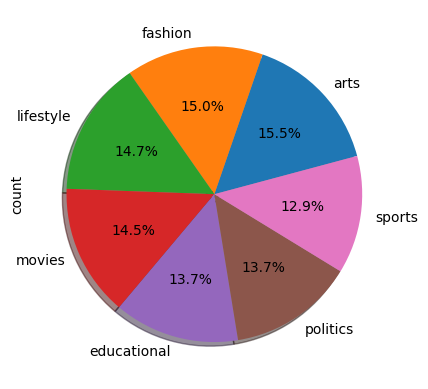

In [21]:
# Plot
pc_df.plot.pie(y = 'count',
               labels = pc_df['_id'],
               autopct = '%1.1f%%',
               startangle = 15, 
               shadow = True,
               legend = False)
plt.show()

> Número de posts públicos e privados da categoria **politics**.

In [22]:
# Número de posts públicos e privados da categoria politics
pol_sta = posts.aggregate([{"$match": {"Category": "politics"}},
                           {"$group": {"_id": "$status", "count": {"$sum": 1}}}])

In [23]:
ps_df = pd.DataFrame(list(pol_sta))

In [24]:
ps_df

,_id,count
0,private,148
1,public,126


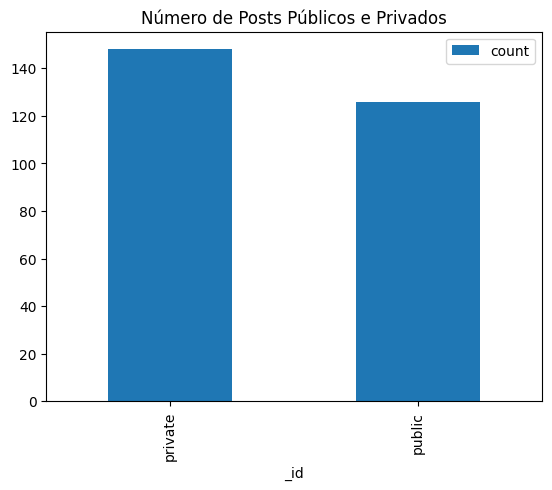

In [25]:
# Plot
ps_df.plot.bar(x = '_id',
               y = 'count',
               title = "Número de Posts Públicos e Privados")
plt.show()

> Qual ano teve o maior número de posts?

In [26]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('684ae69ccb03112702967a7e'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'Concordo plenamente',
 'description': 'O post trouxe uma nova perspectiva. Adorei!',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [27]:
# Update many (cria duas noovas variáveis para cada documento)
datalake.posts.update_many({}, {'$set': {"hour": 0}});
datalake.posts.update_many({}, {'$set': {"year": 0}});

In [28]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('684ae69ccb03112702967a7e'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'Concordo plenamente',
 'description': 'O post trouxe uma nova perspectiva. Adorei!',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': 0,
 'year': 0}

In [29]:
# Update one (atualiza as duas variáveis com os valores correspondentes extraídos da coluna de data)
for data in posts.find({}):
    posts.update_one({"_id": data['_id']},
                     {'$set': {'hour' : data['creationDate'].split('T')[1].split(':')[0],
                               'year' : data['creationDate'].split('T')[0].split('-')[0] }})

In [30]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('684ae69ccb03112702967a7e'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'Concordo plenamente',
 'description': 'O post trouxe uma nova perspectiva. Adorei!',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

In [31]:
# Agregação
posts_yr = posts.aggregate([{"$group": {"_id": "$year", "count": {"$sum": 1}}},
                            {"$sort": {"_id.year": 1, "count": 1}}])

In [32]:
py_df = pd.DataFrame(list(posts_yr))
py_df

,_id,count
0,2015,76
1,2016,299
2,2019,303
3,2017,309
4,2021,330
5,2020,334
6,2018,349


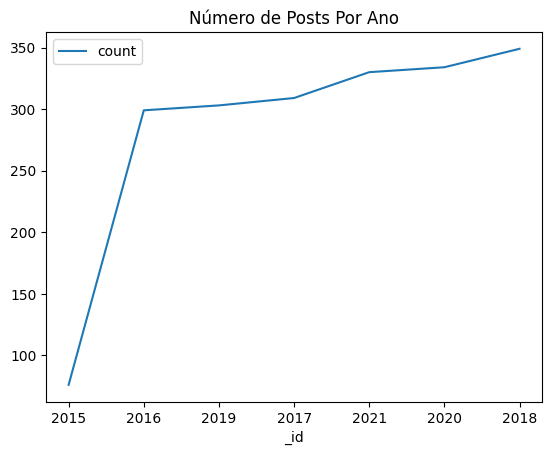

In [33]:
# Plot
py_df.plot.line(x = '_id',
                y = 'count',
                title = "Número de Posts Por Ano")
plt.show()

> Qual o horário com maior número de posts?

In [34]:
# Agregação e ordenação
posts_hr = posts.aggregate([{"$group": {"_id": "$hour", "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

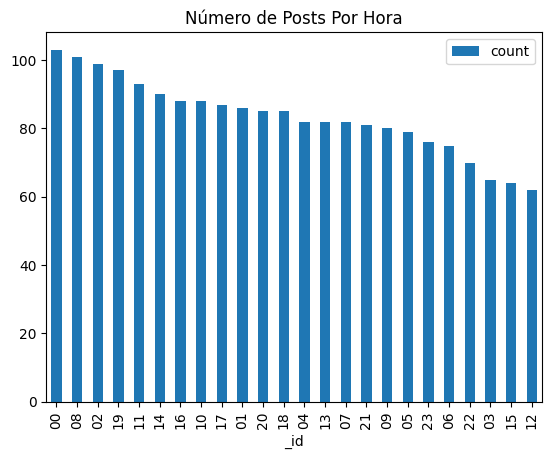

In [35]:
posts_df = pd.DataFrame(list(posts_hr))

posts_df.plot.bar(x = '_id',
                y = 'count',
                title = "Número de Posts Por Hora")
plt.show()

> Número de posts em hora cheia (terminada por 00) por categoria.

In [36]:
# Filtro, agregação e ordenação
cat_00 = posts.aggregate([{"$match": {"hour": "00"}},
                          {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                          {"$sort": {"_id.Category": 1, "count": -1}}])

In [37]:
c0_df = pd.DataFrame(list(cat_00))

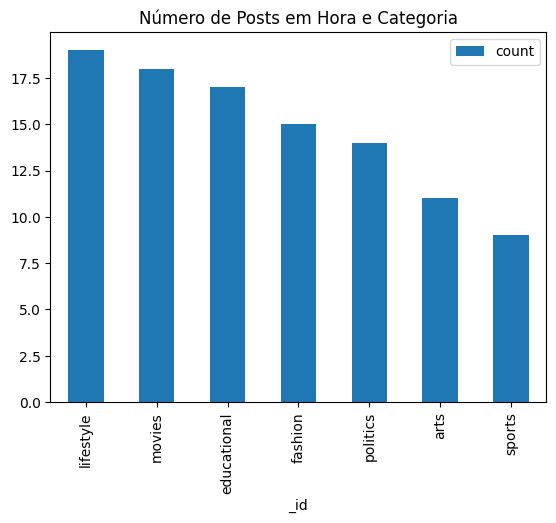

In [38]:
c0_df.plot.bar(x = '_id', 
               y = 'count', 
               title = "Número de Posts em Hora e Categoria")
plt.show()

> Número de posts que permitem comentários.

In [39]:
# Count
com = posts.count_documents({'allowComments':True})

In [40]:
print("Número de Posts Que Permitem Comentários:", com)

Número de Posts Que Permitem Comentários: 964


In [41]:
print("Número de Posts Que Não Permitem Comentários:", n-com)

Número de Posts Que Não Permitem Comentários: 1036


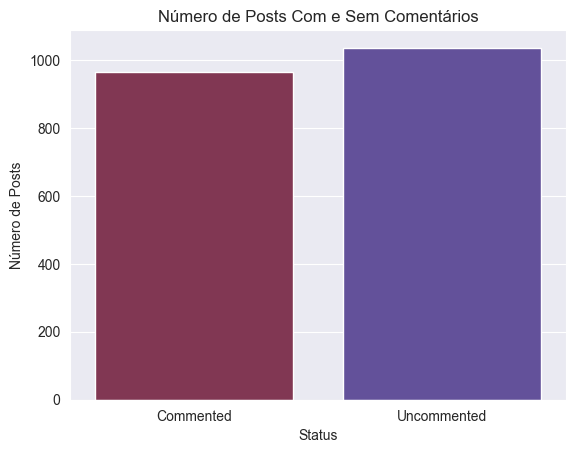

In [42]:
# Plot
sns.set_style('darkgrid')
sns.barplot(x=['Commented', 'Uncommented'], y=[com, n-com], palette = 'twilight_r')
plt.title("Número de Posts Com e Sem Comentários")
plt.xlabel("Status")
plt.ylabel("Número de Posts")
plt.show()

> Comprimento (número de palavras) do título dos posts.

In [43]:
# Retorna 1 item
posts.find_one()

{'_id': ObjectId('684ae69ccb03112702967a7e'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'Concordo plenamente',
 'description': 'O post trouxe uma nova perspectiva. Adorei!',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

In [44]:
# Cria uma nova coluna
datalake.posts.update_many({}, {'$set': {"length_of_heading": 0}});

In [45]:
# Loop para preencher a nova coluna
for data in posts.find({}):
    posts.update_one({"_id": data['_id']},
                     {'$set': {'length_of_heading' : len(data['title'].split(' '))}})

In [46]:
# Agrupamento e ordenação
len_titles = posts.aggregate([{"$group": {"_id": "$length_of_heading", "count": {"$sum": 1}}},
                              {"$sort": {"_id.length_of_heading": 1, "count": -1}}])

In [47]:
len_titles 

In [48]:
title_df = pd.DataFrame(list(len_titles))
title_df.head(10)

,_id,count
0,4,926
1,2,538
2,3,536


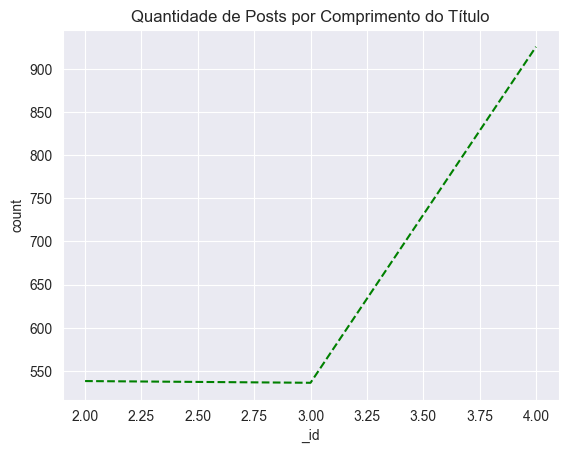

In [49]:
# Plot
ax = sns.lineplot(x = '_id', y = 'count', data = title_df, color = 'green')
ax.lines[0].set_linestyle("--")
plt.title('Quantidade de Posts por Comprimento do Título')
plt.show()

> Número de tags por categoria de posts.

In [50]:
# Agregação
tags = posts.aggregate([{"$group": {"_id": "$tags", "count": {"$sum": 1}}},
                        {"$sort": {"_id.tags": 1, "count": -1}}])

In [51]:
cat_tags = posts.find({'tags': {'$gt':0}}, {'Category':1})
cat_tags

In [52]:
# Categorias com posts com maior número de tags, sendo o número de tags maior do que zero
cat_tags = posts.aggregate([{"$match": {"tags": {"$gt":0}}},
                            {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
                            {"$sort": {"_id.tags": 1, "count": -1}}])

In [53]:
ct_df = pd.DataFrame(list(cat_tags))
ct_df

,_id,count
0,arts,276
1,fashion,276
2,movies,264
3,lifestyle,262
4,politics,258
5,educational,255
6,sports,235


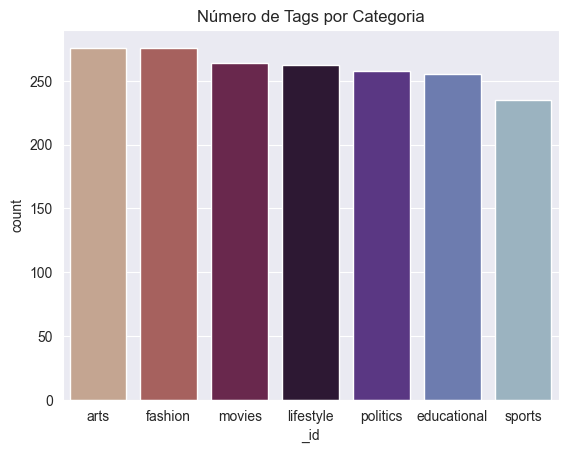

In [54]:
sns.barplot(x = '_id', 
            y = 'count', 
            data = ct_df, 
            palette = 'twilight_r')
plt.title('Número de Tags por Categoria')
plt.show()

> Qual categoria usa mais filtros de fotos/imagens?

In [55]:
# Filtro, agregação e ordenação
cat_fs = posts.aggregate([{"$match": {"filteredPicture": True}},
                          {"$group":{"_id": "$Category", "count": {"$sum": 1}}},
                          {"$sort": {"_id.tags": 1, "count": -1}}])

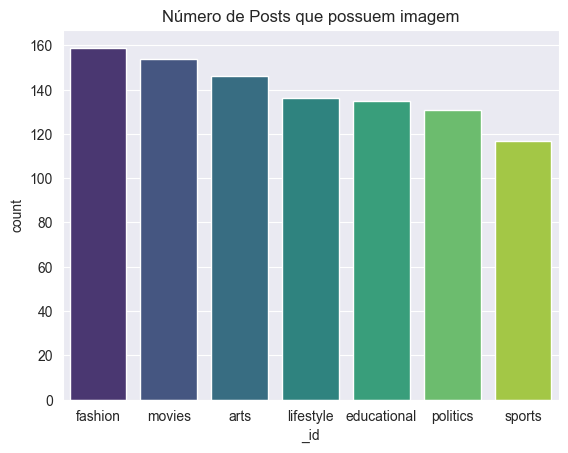

In [56]:
cat_df = pd.DataFrame(list(cat_fs))

sns.barplot(x= '_id',
            y= 'count',
            data= cat_df,
            palette = 'viridis')
plt.title('Número de Posts que possuem imagem')
plt.show()

> Nível Ninja: Qual categoria tem posts (descrição) mais longos (com maior número de palavras), acima de 60 caracteres?

In [57]:
# Cria a variável
datalake.posts.update_many({}, {'$set': {"length_of_des": 0}});

In [58]:
# Loop para preencher a variável
for data in posts.find({}):
    posts.update_one({"_id": data['_id']}, {'$set': {'length_of_des': len(data['description'].split(' '))}})

In [59]:
# Filtro, agregação e ordenação
cat_des = posts.aggregate([{"$match": {"length_of_des": {"$gte":15}}},
                           {"$group":{"_id": "$Category", "count": {"$sum": 1}}},
                           {"$sort": {"_id.tags": 1, "count": -1}}])

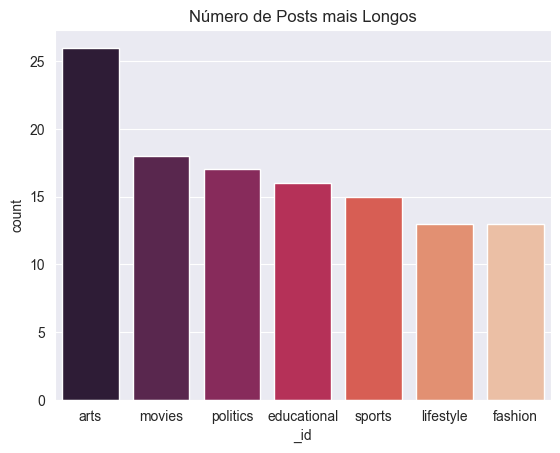

In [60]:
cat_des_df = pd.DataFrame(list(cat_des))

sns.barplot(x= '_id',
            y= 'count',
            data = cat_des_df,
            palette = 'rocket')
plt.title('Número de Posts mais Longos')
plt.show()

> Nível Ninja das Galáxias: O número de posts (descrição) varia de acordo com a hora do dia? Aumenta ou diminui?

In [61]:
# Agregação e ordenação por hora e categoria
posts_hr = posts.aggregate([{"$group": {"_id": ["$hour", "$Category"], "count": {"$sum": 1}}},
                            {"$sort": {"_id.hour": 1, "count": -1}}])

In [62]:
postshr_df = pd.DataFrame(posts_hr)
postshr_df

,_id,count
0,"[11, arts]",23
1,"[08, politics]",21
2,"[16, lifestyle]",20
3,"[11, educational]",20
4,"[10, fashion]",19
...,...,...
163,"[22, politics]",5
164,"[13, sports]",5
165,"[06, sports]",5
166,"[11, lifestyle]",4


In [63]:
# Split
split_df = pd.DataFrame(postshr_df ['_id'].to_list(), columns = ['hour', 'category'])
split_df

,hour,category
0,11,arts
1,08,politics
2,16,lifestyle
3,11,educational
4,10,fashion
...,...,...
163,22,politics
164,13,sports
165,06,sports
166,11,lifestyle


In [64]:
# Concatenação
df = pd.concat([split_df, postshr_df['count']], axis = 1)
df

,hour,category,count
0,11,arts,23
1,08,politics,21
2,16,lifestyle,20
3,11,educational,20
4,10,fashion,19
...,...,...,...
163,22,politics,5
164,13,sports,5
165,06,sports,5
166,11,lifestyle,4


In [65]:
df.head(10)

,hour,category,count
0,11,arts,23
1,08,politics,21
2,16,lifestyle,20
3,11,educational,20
4,10,fashion,19
5,02,lifestyle,19
6,05,arts,19
7,00,lifestyle,19
8,02,politics,18
9,00,movies,18


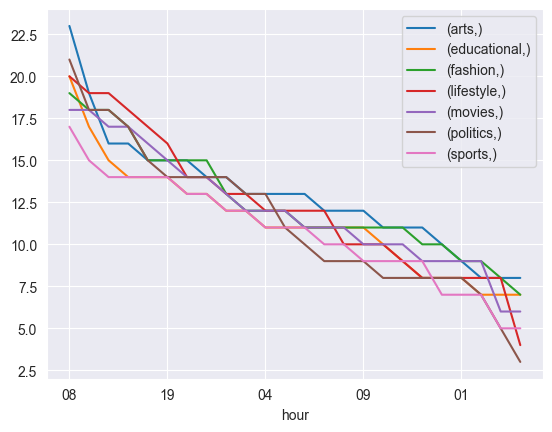

In [66]:
# Plot
fig, ax = plt.subplots()
for key, grp in df.groupby(['category']):
    ax = grp.plot(ax = ax, kind = 'line', x = 'hour', y = 'count', label = key)

plt.legend(loc = 'best')
plt.show()

# Fim